### **INITIALIZATION**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.

### **GETTING THE DATA**
- I am going to use **PASCAL** dataset which has more than one kind of classified object per image. I will download and extract the dataset here. 

In [5]:
#@ GETTING THE DATA: 
path = untar_data(URLs.PASCAL_2007)            # Path to the Dataset. 
path.ls()                                      # Inspecting the Dataset. 

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train')]

In [6]:
#@ INSPECTING THE DATASET: 
data = pd.read_csv(path/"train.csv")           # Reading the Dataset. 
data.head()                                    # Inspecting the Dataset. 

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### **INITIALIZING DATABLOCK AND DATALOADERS**

- **Dataset:** A collection that returns a tuple of independent and dependent variable for a single item. 
- **DataLoader:** An iterator that provides a stream of minibatches where each minibatch is a couple of a batch of independent variables and a batch of dependent variables. 
- **Datasets:** An iterator that contains a training **Dataset** and a validation **Dataset**. 
- **DataLoaders:** An object that contains a training **DataLoader** and a validation **DataLoader**.  

In [7]:
#@ CREATING A DATABLOCK:
dblock = DataBlock()                             # DataBlock without Parameters. 

In [8]:
#@ CREATING DATASETS: 
dsets = dblock.datasets(data)                    # Datasets with DataFrame. 
dsets.train[0]                                   # Inspecting Datasets. 

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [9]:
#@ CREATING DATABLOCK WITH APPROPRIATE INPUT AND TARGET: 
dblock = DataBlock(get_x=lambda r: r["fname"],            # Getting Inputs. 
                   get_y=lambda r: r["labels"])           # Getting Labels. 
dsets = dblock.datasets(data)                             # Creating Datasets with DataFrame. 
dsets.train[0]                                            # Inspecting Datasets.

('005620.jpg', 'aeroplane')

In [10]:
#@ CREATING DATABLOCK WITH APPROPRIATE INPUT AND TARGET: 
def get_x(r): return r["fname"]                           # Getting Inputs from a Column. 
def get_y(r): return r["labels"]                          # Getting Target Column. 
dblock = DataBlock(get_x=get_x, get_y=get_y)              # Initialzing DataBlock. 
dsets = dblock.datasets(data)                             # Creating Datasets. 
dsets.train[0]                                            # Inspecting Datasets. 

('002549.jpg', 'tvmonitor')

In [11]:
#@ CREATING DATABLOCK WITH APPROPRIATE INPUT AND TARGET: 
def get_x(r): return path/"train"/r["fname"]              # Getting Inputs. 
def get_y(r): return r["labels"].split(" ")               # Getting Labels. 
dblock = DataBlock(get_x=get_x, get_y=get_y)              # Initializing DataBlock. 
dsets = dblock.datasets(data)                             # Creating Datasets. 
dsets.train[3]                                            # Inspecting Datasets. 

(Path('/root/.fastai/data/pascal_2007/train/002855.jpg'), ['sofa', 'person'])

In [12]:
#@ CREATING DATABLOCK WITH TRANSFORMS: 
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),     # Transformation Blocks. 
                   get_x=get_x, get_y=get_y)                    # Initialization of DataBlock. 
dsets = dblock.datasets(data)                                   # Creating Datasets. 
dsets.train[0]                                                  # Inspecting Datasets. 

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

**ONEHOT ENCODING**
- Using a vector of 0s with a 1 in each location that is represented in the data to encode a list of integers is called **OneHot Encoding**. 

In [13]:
#@ INSPECTING CATEGORIES:
idxs = torch.where(dsets.train[0][1]==1.)[0]                    # Getting Categories. 
dsets.train.vocab[idxs]                                         # Inspecting Categories. 

(#1) ['dog']

In [14]:
#@ CREATING DATABLOCK WITH SPLITTING:
def splitter(data):                                             # Function for Splitting Data. 
    train = data.index[~data["is_valid"]].tolist()              # Training Dataset. 
    valid = data.index[data["is_valid"]].tolist()               # Validation Dataset. 
    return train, valid

#@ CREATING DATABLOCK WITH SPLITTING: 
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),     # Transformation Block. 
                   splitter=splitter,                           # Splitting the Dataset. 
                   get_x=get_x, get_y=get_y)                    # Initializing DataBlock. 
dsets = dblock.datasets(data)                                   # Creating Datasets. 
dsets.train[0]                                                  # Inspecting Datasets. 

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

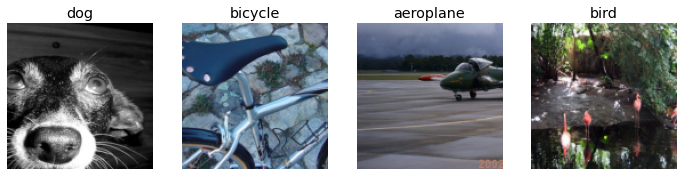

In [15]:
#@ CREATING DATABLOCK WITH SAME SIZE: 
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),             # Transformation Blocks. 
                   splitter=splitter, get_x=get_x, get_y=get_y,         # Splitting the Dataset. 
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))    # Resizing and Cropping. 
dls = dblock.dataloaders(data)                                          # Creating DataLoaders. 
dls.show_batch(nrows=1, ncols=4)                                        # Inspecting Images. 

In [16]:
#@ INSPECTING SUMMARY OF DATALOADERS: UNCOMMENT BELOW:
# dblock.summary(data)

### **BINARY CROSSENTROPY**
- I will create a **Learner** which contains four things such as the model, a **DataLoaders** object, an **Optimizer** and the loss function to use. 

In [18]:
#@ INITIALIZING THE LEARNER: 
learn = cnn_learner(dls, resnet18)                  # Initializing the Learner. 

In [19]:
#@ GETTING ACTIVATIONS: 
x, y = to_cpu(dls.train.one_batch())                # Getting a Minibatch. 
activs = learn.model(x)                             # Getting Activations. 
activs.shape                                        # Inspecting Activations. 

torch.Size([64, 20])

In [20]:
#@ INSEPCTING ACTIVATIONS: 
activs[0]                                           # Inspecting One Activations. 

tensor([ 4.6899, -2.1506,  1.6495,  1.1064,  0.5337,  1.2251, -0.8652, -0.9666, -3.0572, -2.5349, -1.6721, -1.5978,  1.8341, -0.0744,  2.6549,  1.1398, -1.5303, -1.2815,  0.5111,  1.1299],
       grad_fn=<SelectBackward>)

In [21]:
#@ DEFINING BINARY CROSS ENTROPY LOSS FUNCTION: 
def binary_cross_entropy(inputs, targets):          # Initializing the Function. 
    inputs = inputs.sigmoid()                       # Initializing Sigmoid.
    return -torch.where(targets==1, inputs, 
                        1-inputs).log().mean()      # Getting Loss. 

**Note:**
- **F.binary_cross_entropy** and its module equivalent **nn.BCELoss** calculate cross entropy on a one hot encoded target but don't include the initial sigmoid. Normally, **F.binary_cross_entropy_with_logits** or **nn.BCEWithLogitsLoss** do both sigmoid and binary cross entropy in a single function. 
- Similarly for single label dataset, **F.nll_loss** or **nn.NLLoss** for the version without initial softmax and **F.cross_entropy** or **nn.CrossEntropyLoss** for the version with initial softmax. 

In [22]:
#@ INITIALIZING BINARY CROSS ENTROPY LOSS FUNCTION: 
loss_func = nn.BCEWithLogitsLoss()                 # Initializing Loss Function. 
loss = loss_func(activs, y)                        # Getting Loss. 
loss                                               # Inspecting Mean Loss. 

TensorMultiCategory(1.0801, grad_fn=<AliasBackward>)

In [23]:
#@ DEFINING ACCURACY FUNCTION: 
def accuracy(inp, targ, axis=-1):                             # Function for Accuracy. 
    """Computing accuracy with targ when pred is
    bs * n_classes"""
    pred = inp.argmax(dim=axis)                               # Getting Highest Activation. 
    return (pred==targ).float().mean()                        # Getting Mean. 

#@ DEFINING ACCURACY FUNCTION FOR MULTILABEL: 
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):      # Function for Accuracy. 
    "Computing accuracy when inp and targ are the same size"
    if sigmoid: inp.sigmoid()                                 # Initializing Sigmoid Activation. 
    return ((inp>thresh)==targ.bool()).float().mean()         # Getting Mean. 

In [24]:
#@ INSPECTING IMPLEMENTATION OF PARTIAL:
def say_hello(name, say_what="Hello"):                        # Function Example. 
    return f"{say_what} {name}."
say_hello("Thinam"), say_hello("Thinam", "Hey!")              # Inspecting. 

('Hello Thinam.', 'Hey! Thinam.')

In [25]:
#@ INSPECTING IMPLEMENTATION OF PARTIAL: 
f = partial(say_hello, say_what="Namaste")
f("Thinam")

'Namaste Thinam.'

In [27]:
#@ TRAINING THE MODEL WITH ACCURACY THRESHOLD: 
learn = cnn_learner(dls, resnet50,                                  # Initializing Convolutions. 
                    metrics=partial(accuracy_multi, thresh=0.2))    # Initializing Multilabel Accuracy. 
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)                   # Tuning the Model. 

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.946701,0.684428,0.687829,00:28
1,0.826269,0.566085,0.785617,00:28
2,0.604857,0.203379,0.952530,00:28
3,0.361613,0.125538,0.956156,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136642,0.118383,0.959980,00:29
1,0.117578,0.107606,0.962111,00:29
2,0.097556,0.104224,0.963705,00:29


In [29]:
#@ VALIDATING THE MODEL: LOW THRESHOLD: 
learn.metrics = partial(accuracy_multi, thresh=0.1)           # Initializing Multilabel Accuracy.    
learn.validate()                                              # Initializing Validation.        

(#2) [0.1042240709066391,0.9634661674499512]

In [30]:
#@ VALIDATING THE MODEL: HIGH THRESHOLD: 
learn.metrics = partial(accuracy_multi, thresh=0.99)          # Initializing Multilabel Accuracy.    
learn.validate()                                              # Initializing Validation.        

(#2) [0.1042240709066391,0.9625099301338196]

In [31]:
#@ GETTING THRESHOLDS: 
preds, targs = learn.get_preds()                              # Getting Predictions. 
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)       # Getting Multilabel Accuracy. 

TensorMultiCategory(0.9575)

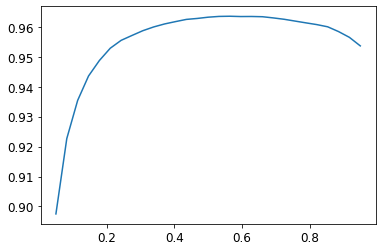

In [32]:
#@ GETTING THRESHOLDS: 
xs = torch.linspace(0.05, 0.95, 29)                           # Initialization. 
accs = [accuracy_multi(preds,targs,thresh=i,sigmoid=False) \
        for i in xs]                                          # Getting Multilabel Accuracy. 
plt.plot(xs, accs);                                           # Inspecting Accuracy. 